## Ideal Gas Law Optimization

In this notebook, we will demonstrate how to use LINQX infrastructure components to perform an optimization of the ideal gas law (PV=nRT). There are four main learning objective from this notebook

1. How to create LINQX parameters for chemically relevent workflows
2. How to create commands which can be used in chemically relevent workflows
3. How to create workflows which can run a list of commands and facilitate information transfer between them
4. How to use the EvoTorch optimization package to optimize LINQX workflows

### Other Notebooks

- See `interactive_gas_law_opt.ipynb` for a tutorial on how to build and run workflows/optimization with interactive commands
- See `optimize_mol.ipynb` for a tutorial on how to build and run workflows/optimization with containerized microservices

### Imports

In [1]:
%matplotlib inline
import sys
sys.path.append("../JSON/")

# LINQX imports
from models.parameter.base import ParameterModel
from models.command.base import BaseDriverCommand
from models.workflow.base import BaseDriverWorkflow
from models.optimizer.base import BaseObjectiveFunction

# PyTorch and Optimizer imports
from evotorch import Problem
from evotorch.algorithms import SteadyStateGA
from evotorch.operators import GaussianMutation

# Plotting imports
import matplotlib.pyplot as plt

/home/mmuhober/.conda/envs/llm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define the Parameters

Here we need to define our parameters for use in the LINQX workflow. The first thing that we need to do is to create `ParmaterModels` for each type of parameter involved in the workflow. Since we are working with the idea gas law, we will need `ParameterModel` objects for `volume`, `temperature`, and `pressure`. In these `ParameterModel` objects attributes like data type and values can be restricted.

After creating the `ParameterModel` objects, we can build them into `Parameter` subclasses using the `to_param()` function. These subclasses can be used to define individual `Parameter` objects for specific parameters. We do this for each parameter (`volume`, `temperature`, `pressure`). 

After creating these parameters, we may need to have a parameter read in from a varaible when it is used in a command in the workflow. In order to do this, we do the following:

```python
parameter.from_var = True
parameter.var_name = "<name_of_varaible>"
```

In [2]:
# Define our parameter Models
volume_mode = ParameterModel(
    name="Volume",
    data_type="float",  # Volume data type will be a float
    upper_limit=100.0,  # Upper limit of volume is 100 L
    lower_limit=10.0,   # Lower limit of volume is 10 L
    default=50.0        # Default value will be 50 L
)
temperature_model = ParameterModel(
    name="Temperature",
    data_type="float",  # Temperature data type will be a float
    upper_limit=400.0,  # Upper limit of temperature is 400 K
    lower_limit=200.0,  # Lower limit of temperature is 200 K
    default=300.0       # Default value will be 300 K
)
pressure_model = ParameterModel(
    name="Pressure",
    data_type="float",
)

# Define our parameter objects
Volume = volume_mode.to_param()
Temperature = temperature_model.to_param()
Pressure = pressure_model.to_param()

# Define our parameters
vol = Volume()
temp = Temperature()
pressure = Pressure()

# The pressure parameter will be read from the output of the ideal gas law function
# Thus we need to say that this parameter will come from a varaible
pressure.from_var = True
pressure.var_name = "pressure"

### Create the Functions Used in the Workflow

LINQX workflows operate as a collection of black box microservices which can transfer information between eachother. The most general example of a microserivce is a user defined python function which take is an input, performs some operation, and returns some output.

In our example, we define two function:

```python
def ideal_gas_law(t: float, v: float) -> float:
```
A function which takes in `temperature` and `volume` as inputs and outputs `pressure` calculated by the ideal gas law

```python
def pressure_volume_avg(p: float, v: float, t: float) -> float:
```
A function which takes in `pressure` and `volume` as inputs and outputs the normalized mean of the two values

In [3]:
# Define our function for the idea gas law
def ideal_gas_law(t: float, v: float) -> float:
    # Return a dictionary with the calculated pressure
    return {
        "pressure": ((6.022e23)*(1.381e-23)*t)/v # PV = NkBT for 1 mol -> PV = RT
    }

# Define our function for the normalized average of the volume and pressure
def pressure_volume_avg(p: float, v: float, t: float) -> float:
    # Return a dictionary with the pressure, volume average
    return {
        "average": ((p/332.65528000000006)+(v/100.0))/2
    }

# Run the functions to test
print(ideal_gas_law(300, 50.0))
print(pressure_volume_avg(ideal_gas_law(300, 50.0)["pressure"], 50.0, 300))

{'pressure': 49.898292}
{'average': 0.32499999999999996}


### Build the Commands

After defining the functions that will be used as microservices, we need to build those functions in `DriverCommand` objects which prevent functions from being called with invalid parameters. We create one command per microservice in the below cell:

In [4]:
gas_law_command = BaseDriverCommand(
    name="Ideal Gas Law",
    parameters= {
        "t": temp,
        "v": vol
    },
    uuid="localhost",
    fn=ideal_gas_law,
    has_return=True
)

avg_command = BaseDriverCommand(
    name="Average",
    parameters= {
        "p": pressure,
        "v": vol,
        "t": temp
    },
    uuid="localhost",
    fn=pressure_volume_avg,
    has_return=True
)

# Test the commands
log = gas_law_command()
print(log)
print(avg_command(p=log["pressure"]))

{'pressure': 49.898292}
{'average': 0.32499999999999996}


### Build the Workflow

After building `DriverCommands` for each microserivce, we need to build a `DriverWorkflow` which executes the commands in order and allows for information to be transfered between commands. We want to first calculate the `pressure` given `temperature` and `volume` (`gas_law_command`) and then get the normalized average of `pressure` and `volume` (`avg_command`).

We need to transfer the output of the `gas_law_command` (`pressure`) to the `avg_command` so we use `list_save_vars` to save off the `pressure`. We also need to save off the `average` as it is our fitness value for optimization.

We can call the `exec()` method of the workflow to execute this workflow.

In [5]:
gas_law_workflow = BaseDriverWorkflow(
    name="Idea Gas Law Workflow",
    commands= [
        gas_law_command,    # First we want to calculate the pressure based on the idea gas law
        avg_command         # Then we want to calculate the average of the pressure and volume
    ]
)

# This list facilitates information transfer between commands
list_save_vars = [
    {"pressure": "pressure"},    # We want to save off the idea gas law output 'pressure' to the workflow global 'pressure'
    {"average": "average"}
]

# Run this workflow to test and print the workflow globals
gas_law_workflow.exec(list_save_vars=list_save_vars)
gas_law_workflow.wf_globals

{'pressure': 49.898292, 'average': 0.32499999999999996}

### Build the Objective Function

After building the workflow, we need to wrap it in a objective function which is compatible with the optimization package we are using. In this case, we are using EvoTorch so we need to have an objective function which is compatible.

EvoTorch expects a fitness function which takes a `torch.Tensor` as input. We need to relate the varaibles of the `Tensor` to the parameters of commands in our workflow. We use `order_kwargs` to accomplish this. The attribute `order_kwargs` is designed to take in a list of dictionaries where each dictionary contains what positions of the `Tensor` will be used for specific parameters of the corresponding commands. 

For example:

```python
#               0  1  2  3  4  5  6  7  8  9
input_tensor = [10,20,30,40,50,60,70,80,90,100]
order_kwargs = [
    {"arg_1_var_1": (0,5), "arg_1_var_2": (6,8)},
    {"arg_2_var_1": (8,8), "arg_2_var_2": (9,9)},
]
# After kwarg assignment
list_kwargs = [
    {"arg_1_var_1": [10,20,30,40,50], "arg_1_var_2": [70,80]}
    {"arg_2_var_1": 90, "arg_2_var_2": 100}
]
```

We also need to specify what will be returned by the function. In this case, we want to judge fitness based on the value stored in the `average` key in the workflow globals.

We then define a EvoTorch `Problem` which tries to optimize the average pressure and volume of a system which behaves in accordance with the idea gas law.

In [6]:
# Make the function compatible for optimization (objective function)
obj_fn = BaseObjectiveFunction(
    name="Interactive Optimize Idea Gas Law",
    workflow=gas_law_workflow,                                      # Our interactive workflow which we build
    order_kwargs=[{"t":(0,1), "v":(1,2)}, {"t":(0,1), "v":(1,2)}],  # The first position of the input Tensor is the temperature, the second is the volume
    list_save_vars=list_save_vars,                                  # We want to save off the pressure to the workflow global
    fitness_criteria=["average"],                                   # We want to assess the function on the saved workflow global 'pressure'
)

# Define an EvoTorch optimization problem
problem = Problem(
    objective_sense="max",                          # We want to maximize the pressure
    objective_func=obj_fn,                          # We provided the objective function we define
    initial_bounds=[(275.0, 40.0), (320.0, 60.0)],  # Start off somewhere in the middle
    bounds=[
        (temp.lower_limit, vol.lower_limit),        # We define the bounds based on the bounds of the parameters (lower, upper)
        (temp.upper_limit, vol.upper_limit)
    ],         
    solution_length=2                               # We expecte a solution length of 2 (temperature, pressure)
)

# Define a optimization algorithm searcher based on the problem
# Steady state genetic algorithm using guassian mutation
searcher = SteadyStateGA(problem=problem, popsize=1)
searcher.use(GaussianMutation(problem=problem, stdev=5))

[2023-07-18 18:37:27] INFO     <109485> evotorch.core: Instance of `Problem` (id:47994271212784) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-07-18 18:37:27] INFO     <109485> evotorch.core: Instance of `Problem` (id:47994271212784) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-07-18 18:37:27] INFO     <109485> evotorch.core: Instance of `Problem` (id:47994271212784) -- The `device` of the problem is set as cpu
[2023-07-18 18:37:27] INFO     <109485> evotorch.core: Instance of `Problem` (id:47994271212784) -- The number of actors that will be allocated for parallelized evaluation is 0


### Optimize the Workflow

We run the genetic algorithm 200 times and log the values every 2 steps.

In [7]:
# Define lists to save off the idea gas law varaibles
best_avg = []       # Best average value each iteration
best_temp = []      # Corresponding temperature value 
best_vol = []       # Corresponding volume value

# Run for 5 iterations
for i in range(100):
    # Run the searcher for 3 steps each iteration
    searcher.run(num_generations=2)
    # Save off the best values each time
    best_avg.append(searcher.get_status_value("best_eval"))
    best_temp.append(float(searcher.get_status_value("best")[0]))
    best_vol.append(float(searcher.get_status_value("best")[1]))

# Recalculate the best pressure vased on temp and volume
best_presssure = list(map(lambda t,v: ((6.022e23)*(1.381e-23)*t)/v, best_temp, best_vol))


/home/mmuhober/.conda/envs/llm/lib/python3.9/site-packages/evotorch/core.py:3425: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  shares_storage = self._data.storage().data_ptr() == source._data.storage().data_ptr()


### Plot the Idea Gas Laws Values

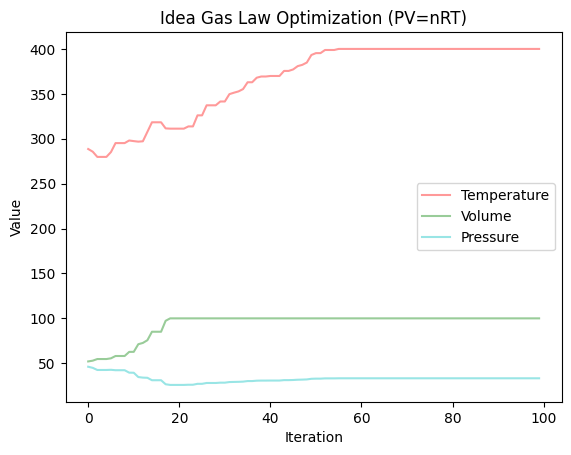

In [8]:
# Plot our results of the optimization
plt.plot([i for i in range(100)], best_temp, 'r-', alpha=0.4, label="Temperature")
plt.plot([i for i in range(100)], best_vol, 'g-', alpha=0.4, label="Volume")
plt.plot([i for i in range(100)], best_presssure, 'c-', alpha=0.4, label="Pressure")

plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Idea Gas Law Optimization (PV=nRT)")
plt.legend()
plt.show()

### Plot the Objective Value

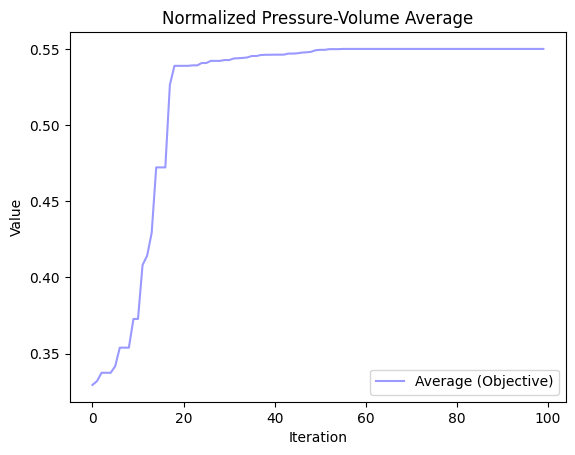

In [9]:
# Plot the results of the optimization
plt.clf()
plt.plot([i for i in range(100)], best_avg, 'b-', alpha=0.4, label="Average (Objective)")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Normalized Pressure-Volume Average")
plt.legend()
plt.show()